# Assignment 6


- PCA vs. OLS

- KNN 

- Dataset: MNIST, Fashion MNIST, Face, Music

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})

import pandas as pd 
from random import sample 
import scipy
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import fetch_lfw_people
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

# PCA VS. OLS

We talked in lecture about the connection between PCA and Least squares in terms of finding a line to fit the data in 2D. We will explore that in this problem. 

Linear regression assume the features are noiseless and the only noisy comes from the labels. 

PCA assume noise can affect both variables.

Simulated data: two independent random variables, each from a Normal distribution with mean $0$. 

then rotates the data by an angle $\dfrac{\pi}{3}$ and the shift along first axis by $2$. 


true line go through 2 data points $(1,-\sqrt 3),(3, \sqrt 3)$

$$x_2 = \sqrt 3 x_1 -2 \sqrt 3$$



## OLS

Use least-squares regression to fit a line (with a slope and intercept) to the data generated above. 

Create a plot that displays the data, 

the true line (the one you found above), 

and the least-squares regression line where you regress $x2$ as a function of $x1$ 

and the other least-squares regression line where you regress $x1$ as a function of $x2$

$$
\begin{align}
x_2 
&= \texttt{mod1.coef\_} * x_1 + \texttt{mod1.intercept\_} \\[1em]
&= \frac{x_1 - \texttt{mod2.intercept\_}}{\texttt{mod2.coef\_}}
\end{align}
$$

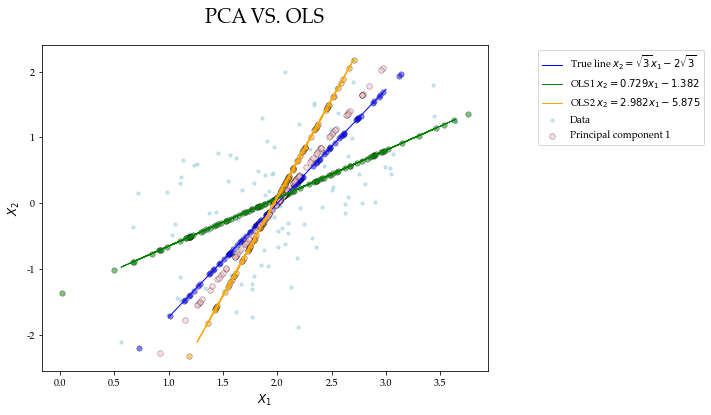

In [69]:
np.random.seed(0)
n = 100 
X = np.random.randn(2,n)
X=X*np.array([1,0.5])[:,None]

# rotate data by degree theta
theta = -np.pi/3
R = np.array([np.cos(theta), np.sin(theta), -np.sin(theta), np.cos(theta)]).reshape(2,2) # rotation matrix (2, 2)
X = R@X
# shift data along first axis by 2
X = X+np.array([2,0])[:,None]

# regress $x2$ as a function of $x1$ 
mod1 = LinearRegression().fit(X[0,:][:,None], X[1,:])

# regress $x1$ as a function of $x2$
mod2 = LinearRegression().fit(X[1,:][:,None], X[0,:])


# project data onto True line
u = np.array([0.5, np.sqrt(3)/2])
projX_1 = (u @ (X-np.array([2,0]).reshape(2,1))) * u[:,None]+np.array([2,0]).reshape(2,1)


# project data onto fitted line of least square 1
u = np.array([1, mod1.coef_[0]])
u /= np.linalg.norm(u)
projX_2 = (u @ (X-np.array([0,mod1.intercept_]).reshape(2,1)))*u[:,None]+np.array([0,mod1.intercept_]).reshape(2,1)

# project data onto fitted line of least square 2
u = np.array([mod2.coef_[0], 1])
u /= np.linalg.norm(u)
projX_3 = (u @ (X-np.array([mod2.intercept_, 0]).reshape(2,1)))*u[:,None]+np.array([mod2.intercept_, 0]).reshape(2,1)

# project data onto first principal component of PCA
u,s,vt = np.linalg.svd(X-np.array([2,0]).reshape(2,1))
uk = u[:,0]
projX_4 = (uk @ (X-np.array([2,0]).reshape(2,1))) * uk[:,None]+np.array([2,0]).reshape(2,1)


plt.figure(figsize=(8, 6))

plt.plot((np.array([-0.5,0.5])*2+2), (np.sqrt(3)*np.array([-1,1])),linewidth=1, c='blue', label=r'True line $x_2 = \sqrt{3} x_1 -2 \sqrt{3}$')
plt.plot(X[0,:], mod1.predict(X[0,:][:,None]),linewidth=1, c='green',label=rf'OLS1 $x_2 = {round(mod1.coef_[0], 3)} x_1 {round(mod1.intercept_, 3)}$')
plt.plot(mod2.predict(X[1,:][:,None]), X[1,:],linewidth=1, c='orange',label=rf'OLS2 $x_2 = {round(1/mod2.coef_[0], 3)} x_1 {round(-mod2.intercept_/mod2.coef_[0], 3)}$')

plt.scatter(np.array(X[0,:]), np.array(X[1,:]), alpha=.70, s=10, c='lightblue', label="Data")
plt.scatter(projX_1[0,:], projX_1[1,:],s=30, alpha=0.5, c='blue', edgecolors='black', linewidth=0.5)
plt.scatter(projX_2[0,:], projX_2[1,:],s=30, alpha=0.5, c='green', edgecolors='black', linewidth=0.5)
plt.scatter(projX_3[0,:], projX_3[1,:],s=30, alpha=0.5, c='orange', edgecolors='black', linewidth=0.5)
plt.scatter(projX_4[0,:], projX_4[1,:],s=30, alpha=0.5, c='pink', edgecolors='black', linewidth=0.5, label='Principal component 1')

plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel(r"$X_1$", fontsize=12)
plt.ylabel(r"$X_2$", fontsize=12)
plt.title("PCA VS. OLS", fontsize=20, y=1.05)
plt.show()

- Explain why least-squares regression and principal components analysis give different fits to the data. 

    Is one better than the other?

**Answer**: The different methods serve different purposes. 

Least squares aims to minimize prediction error, while the PC reconstruction minimizes low-rank reconstruction error.

In [75]:
# prediction error
preds = [(X[0,:]-2)*np.sqrt(3), 
         mod1.predict(X[0,:][:,None]), 
         1/mod2.coef_[0] * X[0,:] - mod2.intercept_/mod2.coef_[0]]

pred_errors = [np.linalg.norm(pred - X[1,:])**2 for pred in preds]
pred_errors.append(pd.NA)

# reconstruction error
projs = [projX_1, projX_2, projX_3, projX_4]
reconst_errors = [np.linalg.norm(proj - X)**2 for proj in projs]

error_df = pd.DataFrame(data={'pred_error': pred_errors, 'reconst_error': reconst_errors}, 
             index=['True', 'OLS 1', 'OLS 2', 'PC1'])
error_df

,pred_error,reconst_error
True,107.726192,26.931548
OLS 1,66.416569,43.351857
OLS 2,271.525129,27.448503
PC1,<NA>,26.443366


# MNIST and  Fashion MNIST

files in MNIST and FASHION-MNIST follows the same structure as MNIST. 

List of files:<br>

training data: train-images-idx3-ubyte<br>

training label: train-labels-idx1-ubyte<br>

test data: t10k-images-idx3-ubyte<br>

test label: t10k-labels-idx1-ubyte

## Load data

In [77]:
def loadimages(dataset):
    """ Load MNIST/fashionMNIST training and test data"""
    if dataset == 'fashionmnist':
        leadstring='/Users/wenxinxu/Desktop/SDS565/data/fashionMNIST/'
    elif dataset == 'mnist':
        leadstring='/Users/wenxinxu/Desktop/SDS565/data/MNIST/'

    ## training data and labels
    # load training image data
    f=open(leadstring + 'train-images-idx3-ubyte','rb')
    gimage=f.read()
    f.close()

    # load training labels
    f=open(leadstring + 'train-labels-idx1-ubyte','rb')
    g=f.read()
    f.close()

    n_train = 60000
    n_test = 10000
    dimH, dimW = 28, 28

    # create training matrix 60000 x 28 x 28
    train=np.array(bytearray(gimage[16:])).reshape(n_train,dimH,dimW)
    # train.shape = (n_train,dimH,dimW)
    train_labels=np.array(bytearray(g[8:]))

    ## load image data
    f=open(leadstring + 't10k-images-idx3-ubyte','rb')
    gimage=f.read()
    f.close()

    ## load labels
    f=open(leadstring + 't10k-labels-idx1-ubyte','rb')
    g=f.read()
    f.close()

    # create test matrix 10000 x 28 x 28
    test=np.array(bytearray(gimage[16:])).reshape(n_test,dimH,dimW)
    # test.shape=(n_test,dimH,dimW)
    test_labels=np.array(bytearray(g[8:]))

    return (train,train_labels,test,test_labels)


In [164]:
a = loadimages('fashionmnist')

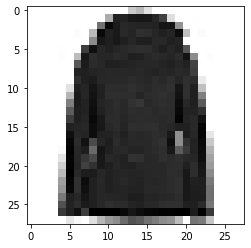

In [165]:
plt.imshow(a[0][2000],cmap=plt.cm.gray.reversed())

## PCA for Dimension Reduction

approximately reconstruct images by simplifying them to multiples of a few principal components.

Note: When display the images, 

- use the color map `cmap=plt.cm.gray.reversed()` for MNIST and Fashion MNIST

- use `cmap=plt.cm.gray` for the face data

### MNIST

Pick a random seed in the next cell to select a random image of a handwritten $4$ or $7$ from the MNIST data.

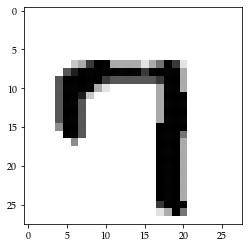

In [80]:
xtrain, train_labels, xtest, test_labels = loadimages('mnist')
x = xtrain.reshape([60000, 28*28])
x = x[np.logical_or(train_labels==4,train_labels==7),:]           # (12107, 784)
y = train_labels[np.logical_or(train_labels==4,train_labels==7)]  # (12107,)

np.random.seed(10) 
my_image = np.random.randint(0, y.shape[0], size=1)

plt.imshow(x[my_image,:].reshape((28,28)), cmap=plt.cm.gray.reversed())

Plot the image of rank $k$ reconstruction for MNIST $4$ and $7$'s for $k = 10, 20, ...,100,110,120$ to approximately reconstruct the image you've selected above. 

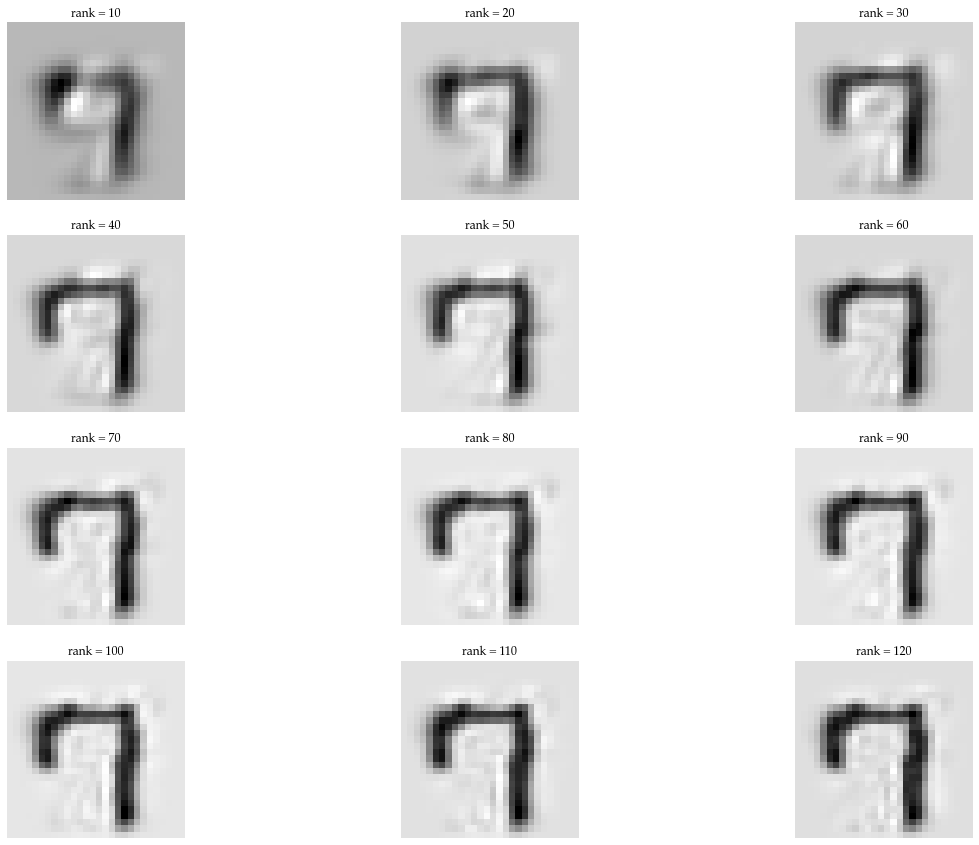

In [82]:
u,s,vt = np.linalg.svd(x-np.mean(x,axis=0)[None,:],full_matrices=False)

f,a = plt.subplots(4,3,figsize=(20,15))
for j in range(4):
    for k in range(3):
        rank = (3*j+k+1)*10  
        reconstruct = vt[:rank].T @ vt[:rank] @ (x[my_image[0],:]-np.mean(x,axis=0)) + np.mean(x,axis=0)
        a[j,k].axis('off')
        a[j,k].imshow(reconstruct.reshape((28,28)),cmap=plt.cm.gray.reversed())
        a[j,k].set_title(f"rank = {rank}")

## fashionMNIST

Plot the image of rank $k$ reconstruction for fashionMNIST $4$ and $7$'s for $k = 10, 20, ...,100,110,120$ to approximately reconstruct the image you've selected. 

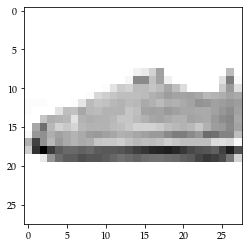

In [83]:
xtrain, train_labels, xtest, test_labels = loadimages('fashionmnist')
x = xtrain.reshape([60000, 28*28])
x = x[np.logical_or(train_labels==4,train_labels==7),:]
y = train_labels[np.logical_or(train_labels==4,train_labels==7)]
np.random.seed(10) # put your seed here
my_image = np.random.randint(0, len(y), size=1)

plt.imshow(x[my_image,:].reshape((28,28)), cmap=plt.cm.gray.reversed())

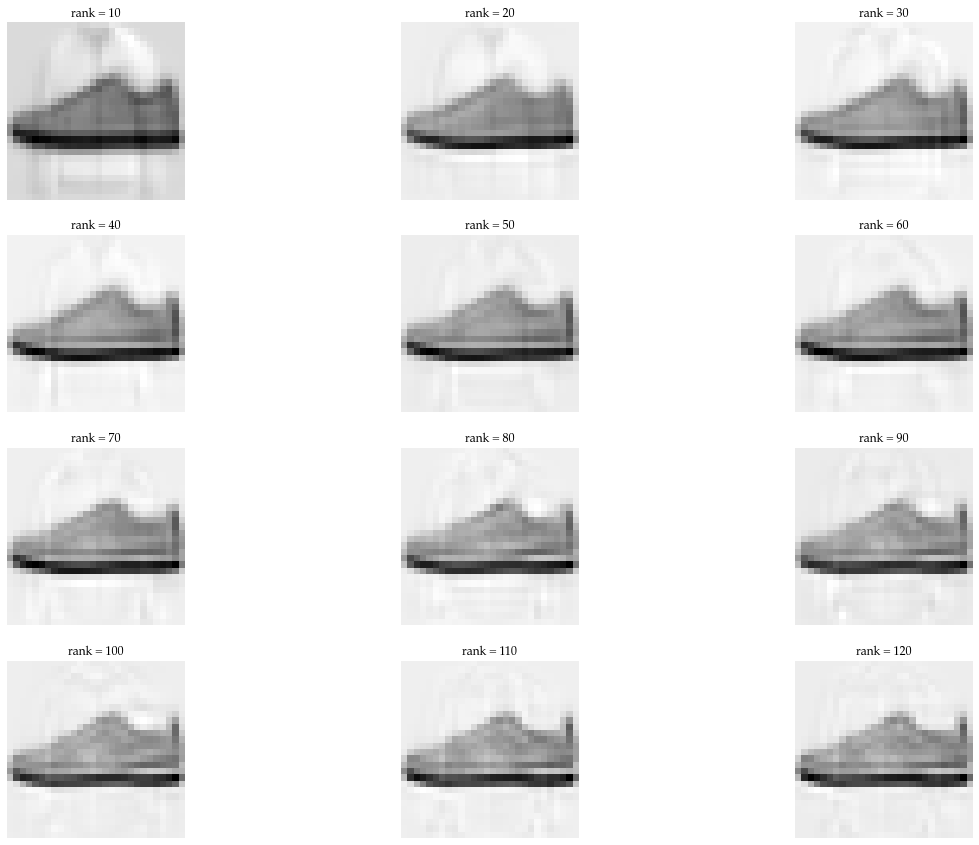

In [84]:
u,s,vt = np.linalg.svd(x-np.mean(x,axis=0)[None,:],full_matrices=False)

f,a = plt.subplots(4,3,figsize=(20,15))
for j in range(4):
    for k in range(3):
        r = (3*j+k+1)*10
        reconstruct = vt[:r].T@vt[:r]@(x[my_image[0],:]-np.mean(x,axis=0))+np.mean(x,axis=0)
        a[j,k].axis('off')
        a[j,k].imshow(reconstruct.reshape((28,28)),cmap=plt.cm.gray.reversed())  
        a[j,k].set_title(f"rank = {r}")

## LFW face dataset

### load data

In [ ]:
# load LFW face dataset from sklearn
from sklearn.datasets import fetch_lfw_people

# Load the face subset of people that have at least 70 different pictures, resize the picture to 0.4
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# print the people included in the face subset: 
# totally 7 people, one of them is 'Colin Powell'
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

[70]


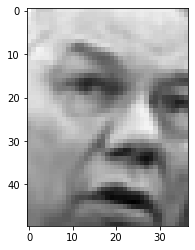

In [ ]:
# feature of training set (1288, 1850) 1850 = 50*37  1288 images in total
x = lfw_people.data 

# label of training set (1288,)
y = lfw_people.target 

# Colin Powell is the second person (index=1) in target_names
powell = y==1 

# extract all images of Colin Powell from training set, 236 in total
xpowell = x[powell,:] # (236, 1850)   

np.random.seed(40) #put your seed here

# randomly select 10th image from Colin Powell subset
my_image = np.random.randint(0, np.sum(powell), size=1)

print(my_image)

# print the 10th image from Colin Powell subset
plt.imshow(xpowell[my_image,:].reshape((50,37)), cmap=plt.cm.gray) 

- reconstruct an image of Colin Powell using all of the data

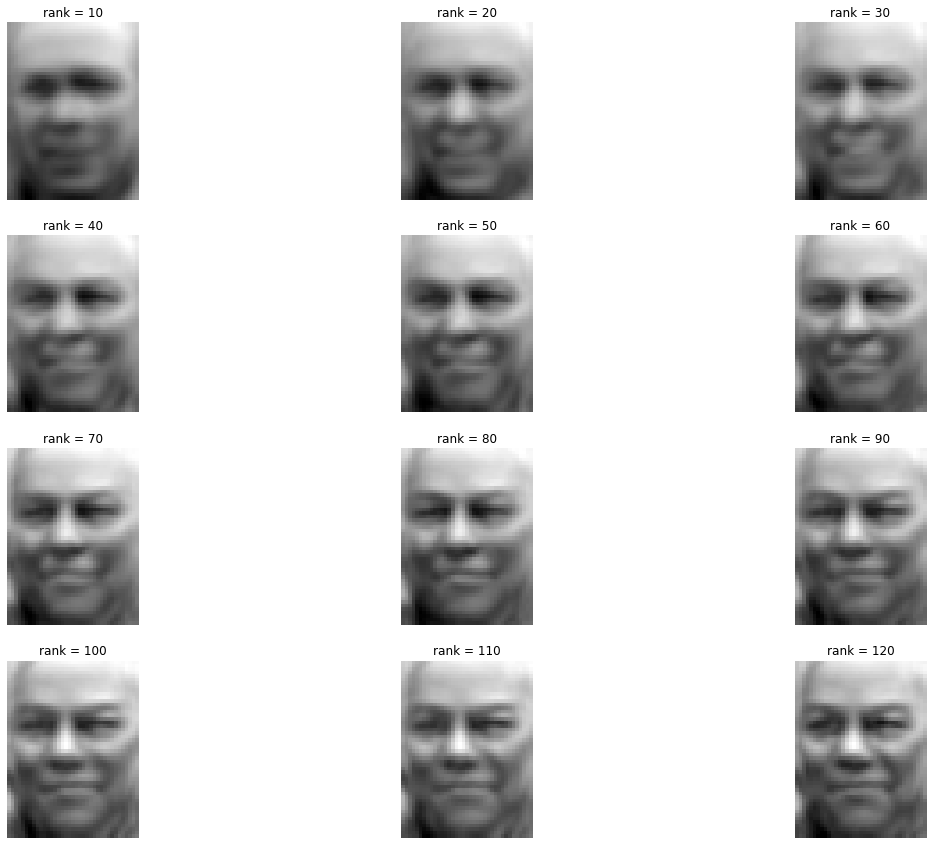

In [187]:
u,s,vt = np.linalg.svd(x-np.mean(x,axis=0)[None,:],full_matrices=False)

f,a = plt.subplots(4,3,figsize=(20,15))
for j in range(4):
    for k in range(3):
        r = (3*j+k+1)*10
        reconstruct = vt[:r].T@vt[:r]@(xpowell[my_image[0],:]-np.mean(x,axis=0))+np.mean(x,axis=0)
        a[j,k].axis('off')
        a[j,k].imshow(reconstruct.reshape((50,37)),cmap=plt.cm.gray) 
        a[j,k].set_title(f"rank = {r}")

- reconstruct Powell's face using only Powell's face

    Comment on any qualitative differences between the reconstructions.

    **Answer**: Works better when just based on Powell

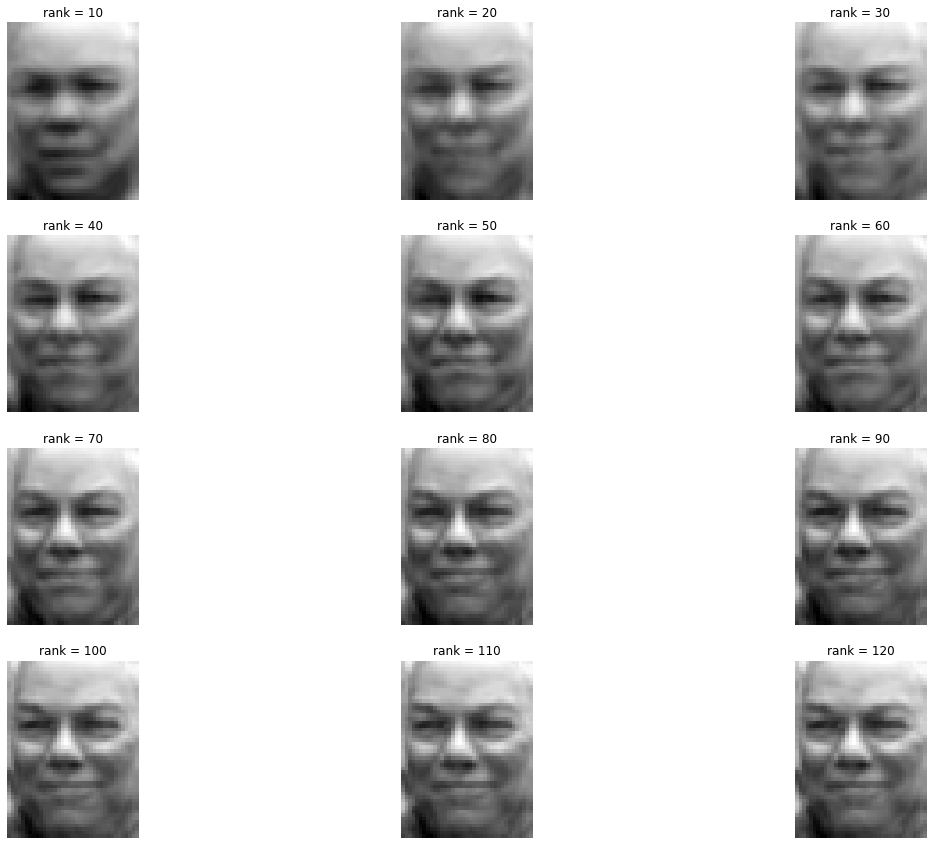

In [215]:
xbackup = x
x=xpowell
u,s,vt = np.linalg.svd(x-np.mean(x,axis=0)[None,:],full_matrices=False)

f,a = plt.subplots(4,3,figsize=(20,15))
for j in range(4):
    for k in range(3):
        r = (3*j+k+1)*10
        reconstruct = vt[:r].T@vt[:r]@(x[my_image[0],:]-np.mean(x,axis=0))+np.mean(x,axis=0)
        a[j,k].axis('off')
        a[j,k].imshow(reconstruct.reshape((50,37)),cmap=plt.cm.gray) ##this is the reconstruction 
        a[j,k].set_title(f"rank = {r}")

# PCA for Classification

## PCA on MNIST

Load in the MNIST. 

Subtract off the mean. 

Use PCA to project the **training** data onto the **first two** principal components, k=2

and create a plot of the projected data color-coded by the label. 

Give a qualitative explanation of your data.

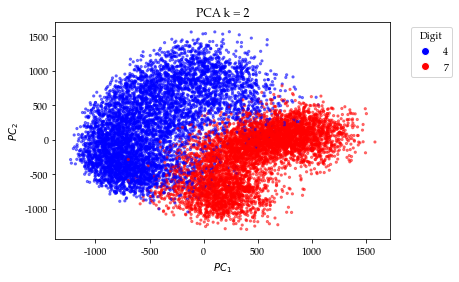

In [94]:
xtrain, train_labels, xtest, test_labels = loadimages("mnist")

## 12107 samples in training set 4,7
xtrain = xtrain.reshape([60000, 28*28])
xtrain = xtrain[np.logical_or(train_labels==4,train_labels==7),:]  # (12107, 784) 
ytrain = train_labels[np.logical_or(train_labels==4,train_labels==7)]  # (12107,)

## 2010 samples in test set 4,7
xtest = xtest.reshape([10000,28*28])
xtest = xtest[np.logical_or(test_labels==4,test_labels==7),:] # (2010, 784)
ytest = test_labels[np.logical_or(test_labels==4,test_labels==7)] # (2010,)

xstand = xtrain - np.mean(xtrain,axis=0)
u,s,vt = np.linalg.svd(xstand,full_matrices=False)
projx = vt[:2] @ xstand.T  # (12107, 2)

plt.scatter(projx[0],projx[1], s=5, alpha=0.5, c=np.where(ytrain == 4,'red','blue'))
legend_elements = [ Line2D([0], [0], marker='o', color='w', label='4',
                          markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='7',
                          markerfacecolor='red', markersize=8)]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1), title='Digit')
plt.xlabel(r"$PC_1$")
plt.ylabel(r"$PC_2$")
plt.title("PCA k = 2")
plt.show()

- plot some images in the 2 different zones (blue, red) of projected data,

    PCA seems to cluster images based on labels.

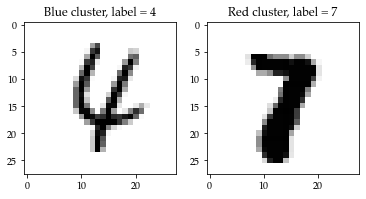

In [96]:
fig, axs = plt.subplots(1, 2)

cond1 = np.logical_and(projx[0]<1,projx[0]>-1)
cond2 = (projx[0]< -1000)
axs[0].imshow(xtrain[cond1][0].reshape(28,28),cmap=plt.cm.gray_r)
axs[1].imshow(xtrain[cond2][0].reshape(28,28),cmap=plt.cm.gray_r)
axs[0].set_title(f"Blue cluster, label = {ytrain[cond1][0]}")
axs[1].set_title(f"Red cluster, label = {ytrain[cond2][0]}")

plt.show()

## logistic regression

For $k = 2,3,4,...,15$, use PCA to project the data onto $k$ principal components. 

For each $k$, use **logistic regression** to build a model to classify images handwriting  4 and 7.

and calculate the **misclassification rate.** 

Create a plot of misclassification rate as a function of $k$

Discuss your results.

Results improve as rank increases, but we might expect loss to increase with more rank.

In [113]:
def trainevallogi(xtrain, ytrain, xtest, ytest, k):
    xshifted = xtrain - np.mean(xtrain,axis=0)
    u,s,vt = np.linalg.svd(xtrain,full_matrices=False)
    projx = xshifted @ vt[:k].T
    fit = LogisticRegression(penalty='l2',C=100).fit(projx, ytrain)
    yhat_train = fit.predict(xshifted @vt[:k].T)
    yhat_test = fit.predict((xtest - np.mean(xtrain,axis=0))@vt[:k].T)
    
    train_error = np.mean(yhat_train != ytrain)
    test_error = np.mean(yhat_test != ytest)
    return train_error, test_error 

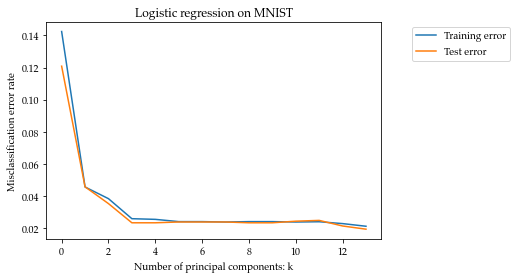

In [114]:
xtrain, train_labels, xtest, test_labels = loadimages("mnist")

## 12107 samples in training set 4,7
xtrain = xtrain.reshape([60000, 28*28])
xtrain = xtrain[np.logical_or(train_labels==4,train_labels==7),:]  # (12107, 784) 
ytrain = train_labels[np.logical_or(train_labels==4,train_labels==7)]  # (12107,)

## 2010 samples in test set 4,7
xtest = xtest.reshape([10000,28*28])
xtest = xtest[np.logical_or(test_labels==4,test_labels==7),:] # (2010, 784)
ytest = test_labels[np.logical_or(test_labels==4,test_labels==7)] # (2010,)

ks = range(2, 16)
train_errors, test_errors = np.zeros(len(ks)), np.zeros(len(ks))
for i, k in enumerate(ks):
    train_errors[i], test_errors[i] = trainevallogi(xtrain/255,ytrain,xtest/255,ytest,k)

plt.plot(train_errors, label = "Training error") 
plt.plot(test_errors, label = "Test error")
plt.xlabel("Number of principal components: k") 
plt.ylabel("Misclassification error rate") 
plt.title("Logistic regression on MNIST")
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

## Plot misclassified images

Build a logistic regression model using $10$ principal components. 

Create a list called `misclass` that lists the indices of all images that were misclassified with this model. 

Run the cell below to create a visualization of the first $16$ of these images. 

Does it make sense that these would be hard to classify correctly?

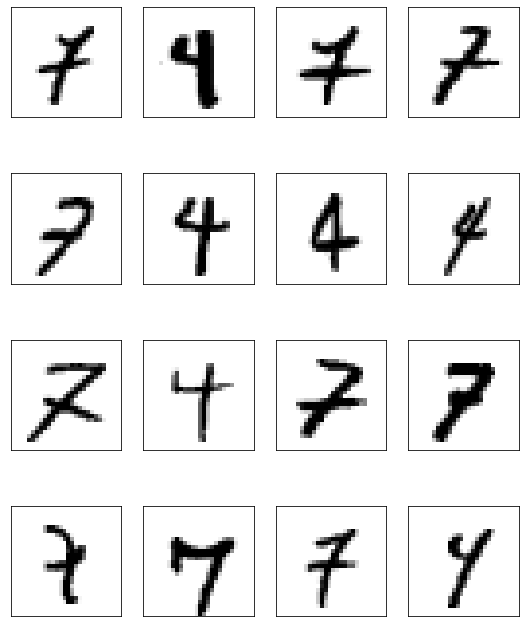

In [107]:
def misclassify(xtrain,ytrain,xtest,ytest,k: int=2):
    """Returns a list of indices of all misclassified images with Logistic regression"""
    xshifted = xtrain - np.mean(xtrain,axis=0)
    u,s,vt = np.linalg.svd(xtrain,full_matrices=False)
    projx = xshifted@vt[:k].T
    fit = LogisticRegression(penalty='none').fit(projx,ytrain)
    yhat = fit.predict((xtest - np.mean(xtrain,axis=0))@vt[:k].T)

    misclass = list(np.arange(0,xtest.shape[0])[yhat != ytest])
    return misclass

misclass = misclassify(xtrain,ytrain,xtest,ytest, k=10)
mis_samples = sample(misclass,16)

plt.figure(figsize=(1.8 * 4, 2.4 * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(xtest[mis_samples[i]].reshape((28, 28)), cmap=plt.cm.gray.reversed())
    plt.xticks(())
    plt.yticks(())

## PCA on Fashion-MNIST

Now use the **Fashion-MNIST** data 

and train **logistic regression** models to classify coats ($y=4$) and handbags ($y=8$). 

Again use $k = 2,3,4,...,15$ to project the data onto $k$ principal components, 

and calculate the misclassification rate at each $k$. 

Create a plot of misclassification rate vs. $k$.

Does your plot make sense? 

Briefly interpret it in 2-3 sentenses.

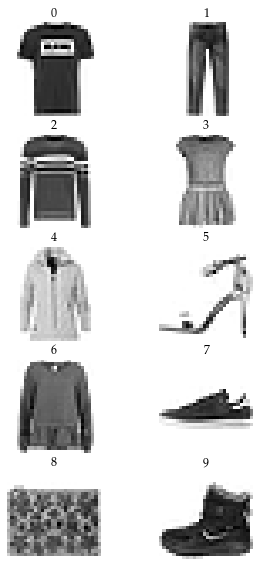

In [111]:
# plot representative images and labels in Fashion-MNIST 
xtrain, train_labels, xtest, test_labels = loadimages('fashionmnist')

f,a = plt.subplots(5,2,figsize=(5,10))
for j in range(5):
    for k in range(2):
        a[j,k].axis('off')
        a[j,k].imshow(xtrain[train_labels==(2*j+k)][0].reshape(28,28),cmap=plt.cm.gray_r) 
        a[j,k].set_title(2*j+k)

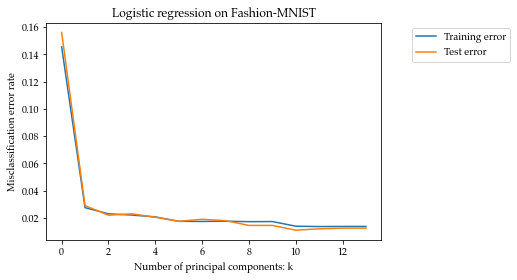

In [115]:
xtrain, train_labels, xtest, test_labels = loadimages('fashionmnist')
xtrain = xtrain.reshape([60000, 28*28])
xtrain = xtrain[np.logical_or(train_labels==4,train_labels==8),:]
ytrain = train_labels[np.logical_or(train_labels==4,train_labels==8)]

xtest = xtest.reshape([10000,28*28])
xtest = xtest[np.logical_or(test_labels==4,test_labels==8),:]
ytest = test_labels[np.logical_or(test_labels==4,test_labels==8)]

ks = range(2, 16)
train_errors, test_errors = np.zeros(len(ks)), np.zeros(len(ks))
for i, k in enumerate(ks):
    train_errors[i], test_errors[i] = trainevallogi(xtrain/255,ytrain,xtest/255,ytest,k)

plt.plot(train_errors, label = "Training error") 
plt.plot(test_errors, label = "Test error")
plt.xlabel("Number of principal components: k") 
plt.ylabel("Misclassification error rate") 
plt.title("Logistic regression on Fashion-MNIST")
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

# Musician low-rank embeddings

There is another dataset under the folder `playlists`. 

2 txt files: `playlists.txt` and `artists.txt`

There are 18111 playlists and 3292 artists.

Each line of `playlists.txt` specifies a list of numbers. 

   Each number is the code for a corresponding artist. 

Each line of `artists.txt` is an artist. 

   The line number (starting at `0`) is the artist code. 



construct a rank $10$ embedding of the artists $A \in \mathbb{R}^{3292 \times 10}$

and use the `sklearn` package **nearest neighbors** to find the `10` closest artists to 'The Notorious B.I.G.'

In [153]:
leadstring = '/Users/wenxinxu/Desktop/SDS565/data/playlists/'
with open(leadstring+'artists.txt','r') as f:
    artists=f.readlines()
pl = pd.read_csv(leadstring+'playlists.txt',header=None)

# a dict mapping code to artist e.g., 941: 'By The Tree'
codetoartist = {j : artists[j].strip() for j in range(len(artists))}

# a dict mapping artist to code e.g., 'By The Tree': 941
artisttocode = {artists[j].strip() : j for j in range(len(artists))}

query = 'The Notorious B.I.G.'
querycode = artisttocode[query] # 2616

d = pl.to_dict()[0]
# a list of tuples for playlist (row index, [codes])  e.g., (1, [30, 1006, 2628, 353])
inds = [(j,[int(k) for k in d[j].strip().split(' ')]) for j in range(len(d))]
# flat code out into a column vector (189900,) all entries are 1
vals = np.ones(len([k for j in inds for k in j[1]])) # (189900,)
# a list of tuples ([repeat row index],[code]) e.g., ([1, 1, 1, 1], [30, 1006, 2628, 353])
i2 = [([j[0]]*len(j[1]),j[1]) for j in inds]

row_ind = [k for j in i2 for k in j[0]]
col_ind = [k for j in i2 for k in j[1]]

# Compressed Sparse Row matrix  X[row_ind[k], col_ind[k]] = data[k]
X = scipy.sparse.csr_matrix((vals,(row_ind, col_ind))) # (18111, 3292) 
A,s,vt = scipy.sparse.linalg.svds(X.T, k=10)

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(A)

[artists[j] for j in nbrs.kneighbors(A[querycode:(querycode+1),:])[1][0]]

['The Notorious B.I.G.',
 'Snoop Dogg',
 "Lil' Jon & The Eastside Boyz",
 '2Pac',
 'Mann',
 'Birdman',
 'T-Pain',
 'Kanye West & Jay-Z',
 'Ludacris',
 'Keyshia Cole']

/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


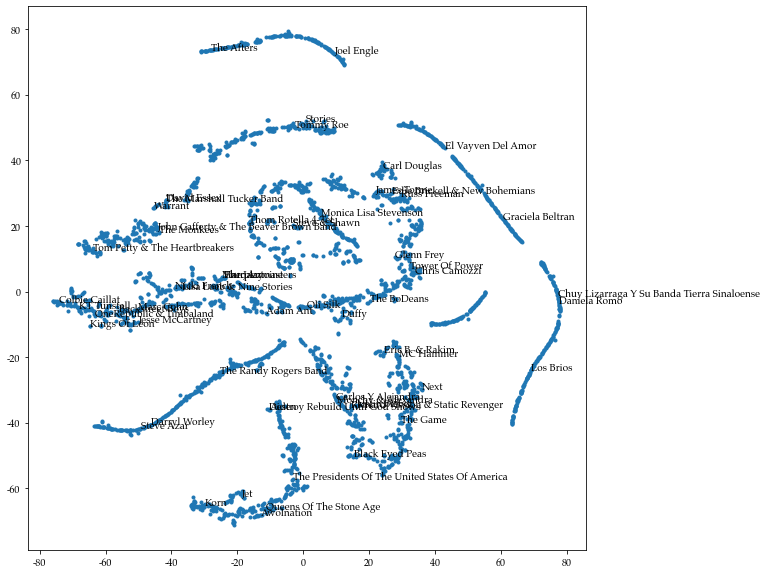

In [143]:
alphahat = TSNE(n_components=2,perplexity=20, init='pca', learning_rate='auto').fit_transform(A) # (3292, 2)

plt.figure(figsize=[10,10])
plt.plot(alphahat[:,0],alphahat[:,1],'.')

someartists = sample(artists,60)
for j in someartists:
    code=artisttocode[j]
    plt.annotate(j, (alphahat[code,0], alphahat[code,1]))
plt.show()
    

In [154]:
# load playlists.txt
with open('/Users/wenxinxu/Desktop/SDS565/data/playlists/playlists.txt','r') as f:
    playlists=f.readlines() # a list

In [182]:
X = np.zeros((len(playlists), len(artists)))

for i in range(len(playlists)):
    
    X[i][[int(code) for code in playlists[i].strip().split()]] = 1

# A.shape (3292, 10)
A,s,vt = scipy.sparse.linalg.svds(X.T ,10) 

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(A)

[artists[j] for j in nbrs.kneighbors(A[querycode:(querycode+1),:])[1][0]]

['The Notorious B.I.G.',
 'Lupe Fiasco',
 '2Pac',
 'T-Pain',
 'Snoop Dogg',
 'Chris Brown & Tyga',
 'Ludacris',
 'Dr. Dre',
 'YC',
 'Mann']